# Data Mining Mini-Project: BERT

## Problem: *Sentiment Classification*

A sentiment classification problem consists, roughly speaking, in detecting a piece of text and predicting if the author likes or dislikes what he/she is talking about: the input $X$ is a piece of text and the output $Y$ is the sentiment we want to predict, such as the rating of a movie review.

If we can train a model to map $X$ to $Y$ based on a labelled dataset then it can be used to predict sentiment of a reviewer after watching a movie.


## Data: *Large Movie Review Dataset v1.0*

The [dataset](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) contains movie reviews along with their associated binary sentiment polarity labels. 

* The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. 
* The overall distribution of labels is balanced (25k pos and 25k neg). 
* 50,000 unlabeled documents for unsupervised learning are included, but they won't be used. 
* The train and test sets contain a disjoint set of movies, so no significant performance is obtained by memorizing movie-unique terms and their associated with observed labels.  
* In the labeled train/test sets, a negative review has a score $\leq$ 4 out of 10, and a positive review has a score $\geq$ 7 out of 10. Thus reviews with more neutral ratings are not included in the train/test sets. 
* In the unsupervised set, reviews of any rating are included and there are an even number of reviews > 5 and $\leq$ 5.

#### Reference 
Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). [Learning Word Vectors for Sentiment Analysis](https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf). The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

## Theory

### The encoder-decoder sequence

Roughly speaking, an encoder-decoder sequence is an ordered collection of steps (*coders*) designed to automatically translate  sentences from a language to another (e.g. the English "the pen is on the table" into the Italian "la penna è sul tavolo"), which could be useful to visualize as follows: **input sentence** → (*encoders*) → (*decoders*) → **output/translated sentence**. <br>

For our practical purpose, encoders and decoders are effectively indistinguishable (that's why we will call them *coders*): both are composed of two layers: a **LSTM or GRU neural network** and an **attention module (AM)**. They only differ in the way in which their output is processed. 

#### LSTM or GRU neural network
Both the input and the output of an LSTM/GRU neural network consists of two vectors: 
1. the **hidden state**: the representation of what the network has learnt about the sentence it's reading;
2. the **prediction**: the representation of what the network predicts (e.g. translation). 

Each word in the English input sentence is translated into its word embedding vector (WEV) before being processed by the first coder (e.g. with `word2vec`). 
The WEV of the first word of the sentence and a random hidden state are processed by the first coder of the sequence. Regarding the output: the prediction is ignored, while the hidden state and the WEV of the second word are passed as input into the second coder and so on to the last word of the sentence. Therefore in this phase the coders work as *encoders*.

At the end of the sequence of N encoders (N being the number of words in the input sentence), the **decoding phase** begins: 
1. the last hidden state and the WEV of the "START" token are passed to the first *decoder*;
2. the decoder outputs a hidden state and a prection; 
3. the hidden state and the prediction are passed to the second decoder; 
4. the second decoder outputs a new hidden state and the second word of the translated/output sentence

and so on up until the whole sentence has been translated, namely when a decoder of the sequence outputs the WEV of the "END" token. Then there is an external mechanism to convert prediction vectors into real words, so it's very importance to notice that **the only purpose of decoders is to predict the next word**.  

#### Attention module (AM)

The attention module is a further layer that is placed before the network which provides the collection of words of the sentence with a relational structure. Let's consider the word "table" in the sentence used as an exampe above. Because of the AM, the encoder will weight the preposition "on" (processed by the previous encoder) more than the article "the" which refers to the subject "cat". 

### Bidirectional Encoder Representations from Transformers (BERT)

#### Transformer
The transformer is a coder endowed with the AM layer. Transformers have been observed to work much better than the basic encoder-decoder sequences.

#### BERT-Base

BERT is a sequence of encoder-type transformers which was pre-trained to *predict* a word or sentence (i.e. used as decoder). The benefit of improved performance of Transformers comes at a cost: the loss of *bidirectionality*, which is the ability to predict both next word and the previous one. BERT is the solution to this problem, a Tranformer which preserves *biderectionality*.

##### Notes  
The first token is not "START". In order to use BERT as a pre-trained language model for sentence-classification, we need to input the BERT prediction of "CLS" into a linear regression because 
* the model has been trained to predict the next sentence, not just the next word; 
* the semantic information of the sentence is encoded in the prediction output of "CLS" as a document vector of 512 elements.

## Documentation 
The full description of the project can be found in this [Github page](https://inphyt.github.io/DataMiningBert/), while all the relevant notebooks are publicly available in the associated [Github repository](https://github.com/InPhyT/DataMiningBert).

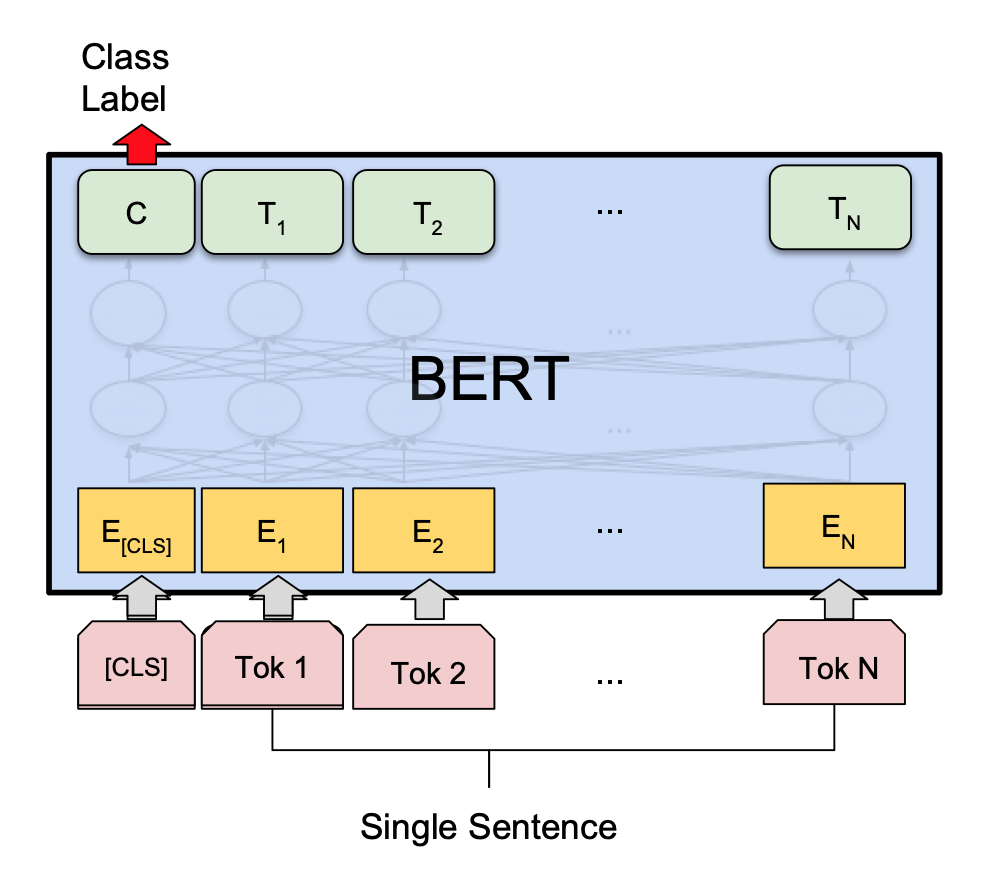

In [1]:
from IPython.display import Image
Image(width= 550, height= 300, filename= '../input/bert-final-data/bert-diagram.png')

# Code
## Import Modules

In [2]:
%%capture
!pip install /kaggle/input/bert-for-tf2/py-params-0.8.2/py-params-0.8.2/
!pip install /kaggle/input/bert-for-tf2/params-flow-0.7.4/params-flow-0.7.4/
!pip install /kaggle/input/bert-for-tf2/bert-for-tf2-0.13.2/bert-for-tf2-0.13.2/
!pip install sentencepiece

%pylab inline
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from bert.tokenization.bert_tokenization import FullTokenizer
import matplotlib.pyplot as plt
import pickle
import numpy as np
import tensorflow.keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from bs4 import BeautifulSoup
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import Image

## Data Loading

In [3]:
# Define the three functions that prepare the input for bert.
# Load data (see Appendix A)
train_data = np.load("../input/imbddatao/data.npz")
test_data = np.load("../input/imbddatao/test.npz")
train = train_data["a"]
train_labels = train_data["b"]
test = test_data["a"]
test_labels = test_data["b"]

# Text maximum length for Bert Base
max_seq_length = 512

For further details on parameters setting (seq length and gpu specifics) see the [github repo](https://github.com/google-research/bert) by Google. 

In [4]:
# Load the Bert base layer.
Bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

## Data Encoding

In [5]:
# Processing Functions
# to distinguish padding from real words ids
def get_masks(tokens, max_seq_length):
    if len(tokens)>max_seq_length:
        #Cutting down the excess length
        tokens = tokens[0:max_seq_length]
        return [1]*len(tokens)
    else:
        return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

# needed to sentencize (we don't use it really).
def get_segments(tokens, max_seq_length):
    if len(tokens)>max_seq_length:
        #Cutting down the excess length
        tokens = tokens[:max_seq_length]
        segments = []
        current_segment_id = 0
        for token in tokens:
            segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
        return segments
    else:
        segments = []
        current_segment_id = 0
        for token in tokens:
            segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
        return segments + [0] * (max_seq_length - len(tokens))
# a bow model
def get_ids(tokens, tokenizer, max_seq_length):    
    if len(tokens)>max_seq_length:
        tokens = tokens[:max_seq_length]
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        return token_ids
    else:
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
        return input_ids

# create a vocabulary
vocab_file = Bert_layer.resolved_object.vocab_file.asset_path.numpy()
# lower case bert function
do_lower_case = Bert_layer.resolved_object.do_lower_case.numpy()
# tokenizer
tokenizer = FullTokenizer(vocab_file, do_lower_case)

# preprocessing function
def bert_encode(texts):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        stokens = tokenizer.tokenize(text)
        stokens = ["[CLS]"] + stokens + ["[SEP]"]
        
        input_ids = get_ids(stokens, tokenizer, max_seq_length)
        input_masks = get_masks(stokens, max_seq_length)
        input_segments = get_segments(stokens, max_seq_length)
        
        all_tokens.append(input_ids)
        all_masks.append(input_masks)
        all_segments.append(input_segments)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def review_to_words(raw_body):
    body_text = BeautifulSoup(raw_body).get_text() 
    return(body_text)  

In [6]:
print("Esempio input:")
print(bert_encode(train[1]))

train_text = [review_to_words(x) for x in train]
test_text =  [review_to_words(x) for x in test]

train_input = bert_encode(train_text)
test_input = bert_encode(test_text)

test_labels = test_labels.astype(float)
train_labels = train_labels.astype(float)

Esempio input:
(array([[ 101, 1040,  102, ...,    0,    0,    0],
       [ 101, 1041,  102, ...,    0,    0,    0],
       [ 101, 1055,  102, ...,    0,    0,    0],
       ...,
       [ 101, 1037,  102, ...,    0,    0,    0],
       [ 101, 1054,  102, ...,    0,    0,    0],
       [ 101, 1012,  102, ...,    0,    0,    0]]), array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]))


## Model Definition

In [7]:
# Define the model.
METRICS = [ 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
]

input_word_ids = tf.keras.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

_ , sequence_output = Bert_layer([input_word_ids, input_mask, segment_ids])
clf_output = sequence_output[:, 0, :] # opzione 1
mean = tf.reduce_mean(sequence_output, 1) # opzione 2
out = Dense(512, activation='relu')(clf_output)
# note: here we could insert a dropout layer: we chose not to put it (so drop = 0) because drop exploration (see Appendix B) pointed no signicant performance oscillation when we vary the drop.
final = Dense(1, activation='sigmoid')(out)
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=final)
# compile and summary
model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=METRICS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

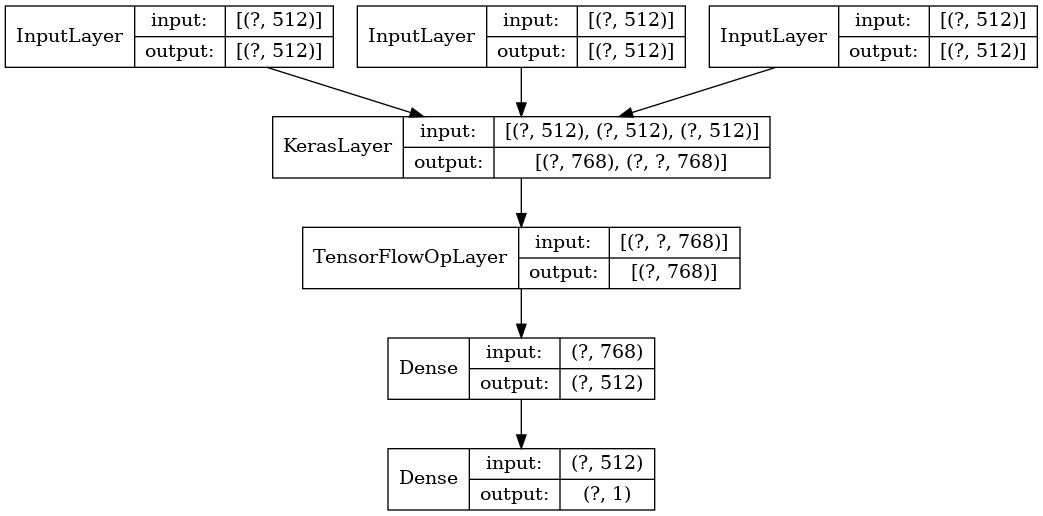

In [8]:
# plot model structure
plot_model(model,show_layer_names  = False,show_shapes = True)

### Model Training & Validation

We train on 20000 and validate on 5000 with early stopping (once set drop = 0 via the exploration). This training has been performed using kaggle's GPU. An unsuccesful attempt with TPU has been done, see [our GitHub repo](https://github.com/InPhyT/DataMiningBert). 

In [9]:
# early stopping
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-2,
        patience=2,
        verbose=1)
]

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=5,
    batch_size=12,
    callbacks=callbacks
)

#model.save('model.h5')

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 1429s 71ms/sample - loss: 0.2670 - accuracy: 0.8915 - auc: 0.9570 - val_loss: 0.2151 - val_accuracy: 0.9126 - val_auc: 0.9744
Epoch 2/5
20000/20000 [==============================] - 1408s 70ms/sample - loss: 0.1539 - accuracy: 0.9454 - auc: 0.9844 - val_loss: 0.2007 - val_accuracy: 0.9206 - val_auc: 0.9770
Epoch 3/5
20000/20000 [==============================] - 1408s 70ms/sample - loss: 0.0967 - accuracy: 0.9689 - auc: 0.9926 - val_loss: 0.2185 - val_accuracy: 0.9222 - val_auc: 0.9757
Epoch 00003: early stopping


In [10]:
# predict
print('\n# Evaluate on test data')
results = model.evaluate(test_input, test_labels, batch_size=12)
print('test loss, test acc, test auc:', results)


# Evaluate on test data
25000/25000 [==============================] - 590s 24ms/sample - loss: 0.1946 - accuracy: 0.9282 - auc: 0.9797
test loss, test acc, test auc: [0.19461815782275052, 0.92816, 0.9797187]


The following plots have been outputted separately because of computational limitations. 

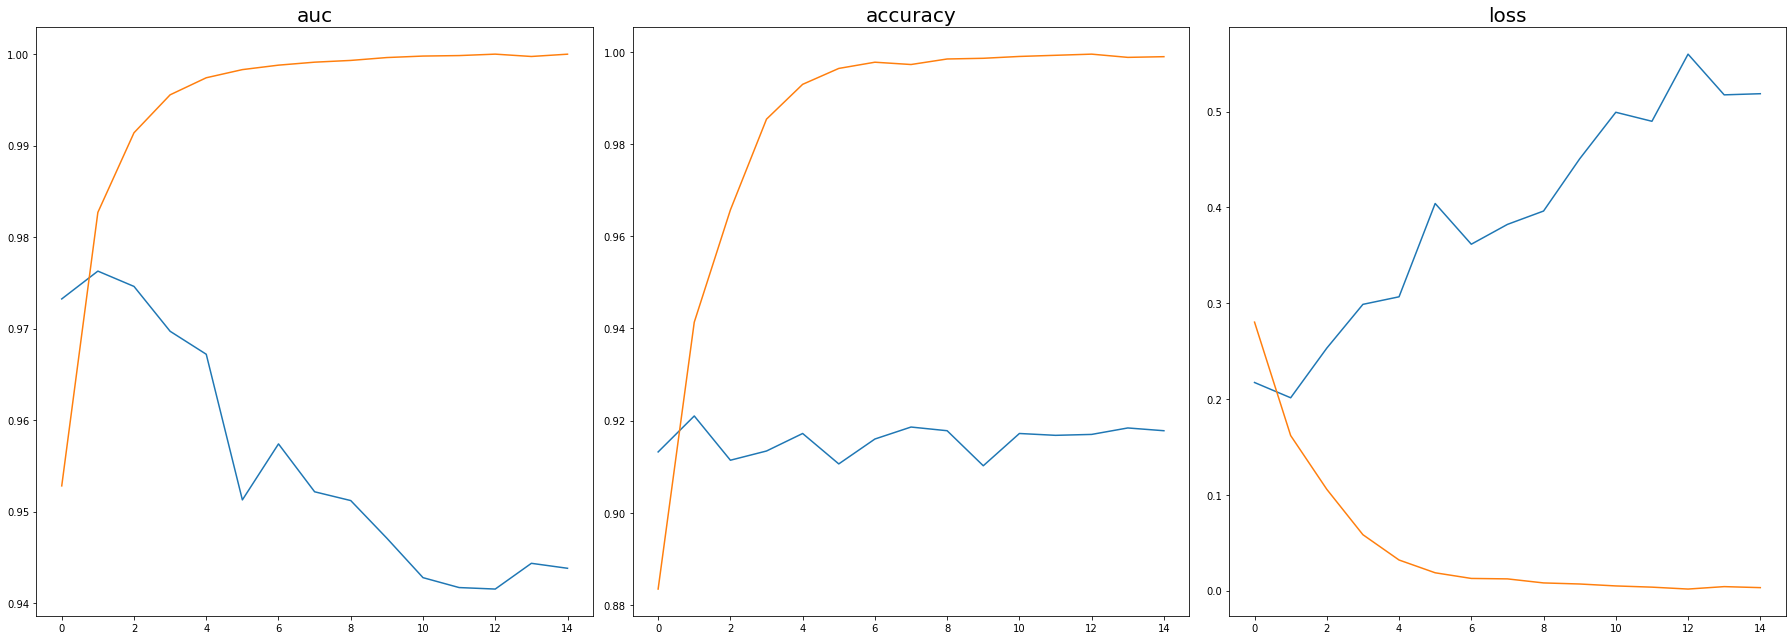

In [11]:
# plot performance-related parameters. Once set drop = 0 (see Appendix B), we trained up to 15 epocs to explore the model.
with open('../input/bert-final-data/trainHistoryDict', 'rb') as f:
        long = pickle.load(f)
        f.close()

figure(figsize=(25, 9))
i = 0
epoch = list(range(15))

for _ in ["auc","accuracy","loss"]:
        i = i+1
        plt.subplot(1, 3, i)
        val = long["val_"+_]
        train = long[_]
        plt.title(_ ,fontsize=20)
        plt.plot(epoch,val,train)
        
plt.tight_layout()

#### Note: to achieve better performance, one may retrain the model on all 25000 data.  It has been not done here for computational time reasons.

```python
train_history = model.fit(
    train_input, train_labels,
    epochs=5,
    batch_size=12,
    callbacks=callbacks
)
```

## BERT-Large 

Although we've not been able to explore all possibilities because of computational limits, BERT-Large shows better performance than BERT-Base as expected.  

In [12]:
Bert_layerL = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1",trainable=True)

vocab_file = Bert_layerL.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = Bert_layerL.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        stokens = tokenizer.tokenize(text)
        stokens = ["[CLS]"] + stokens + ["[SEP]"]
        
        input_ids = get_ids(stokens, tokenizer, max_seq_length)
        input_masks = get_masks(stokens, max_seq_length)
        input_segments = get_segments(stokens, max_seq_length)
        
        all_tokens.append(input_ids)
        all_masks.append(input_masks)
        all_segments.append(input_segments)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

train_input = bert_encode(train_text)
test_input = bert_encode(test_text)

test_labels = test_labels.astype(float)
train_labels = train_labels.astype(float)

input_word_ids = tf.keras.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

_ , sequence_output = Bert_layerL([input_word_ids, input_mask, segment_ids]) 
clf_output = sequence_output[:, 0, :] 
mean = tf.reduce_mean(sequence_output, 1) 
out = tf.keras.layers.Dense(512, activation='relu')(clf_output) #We tried mean three times, with similar results. We couldn't perform futher investigation because of computational limits.
final = tf.keras.layers.Dense(1, activation='sigmoid')(out)

    
modelL = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=final)
modelL.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=METRICS) 

callbacksL = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-2,
        patience=2,
        verbose=1)
]

train_historyL = modelL.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=4,
    batch_size=4,
    callbacks=callbacksL
)

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 4821s 241ms/sample - loss: 0.2009 - accuracy: 0.9220 - auc: 0.9747 - val_loss: 0.1715 - val_accuracy: 0.9360 - val_auc: 0.9835
Epoch 2/4
20000/20000 [==============================] - 4783s 239ms/sample - loss: 0.0836 - accuracy: 0.9733 - auc: 0.9943 - val_loss: 0.2081 - val_accuracy: 0.9330 - val_auc: 0.9822
Epoch 3/4
20000/20000 [==============================] - 4785s 239ms/sample - loss: 0.0274 - accuracy: 0.9928 - auc: 0.9986 - val_loss: 0.2402 - val_accuracy: 0.9348 - val_auc: 0.9754
Epoch 00003: early stopping


In [13]:
# predict Large
print('\n# Evaluate on test data')
resultsL = modelL.evaluate(test_input, test_labels, batch_size=4)
print('test loss, test acc, test auc:', resultsL)


# Evaluate on test data
25000/25000 [==============================] - 1999s 80ms/sample - loss: 0.2116 - accuracy: 0.9406 - auc: 0.9787
test loss, test acc, test auc: [0.2115948600535118, 0.94064, 0.97867084]


#### Note: to achieve better performance, one may retrain the model on all 25000 data. It has been not done here for computational time reasons.


```python
train_history = modelL.fit(
    train_input, train_labels,
    epochs=5,
    batch_size=12,
    callbacks=callbacksL
)
```

## Appendix A: Data Preprocessing

The [dataset](https://ai.stanford.edu/~amaas/data/sentiment/) could not be directly imported into kaggle, so we pre-processed it with the following code on a local machine.

```python
import os
import re
import numpy as np
from os import listdir

docneg = []
docpos = []
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename,encoding="utf8")
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
def process_docs(directory,doc):
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip files that do not have the right extension
        if not filename.endswith(".txt"):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load document
        doc.append([load_doc(path)]) 
        

directoryn = 'IMBDdataset/neg'
directoryp = 'IMBDdataset/pos'
process_docs(directoryn,docneg)
process_docs(directoryp,docpos)
docneg = np.array(docneg)
docpos = np.array(docpos)
docneg = np.insert(docneg, 0, np.ones(docneg.shape[0]), axis=1)
docpos = np.insert(docpos, 0, np.zeros(docpos.shape[0]), axis=1)

#concatenate and shuffle
data = np.comcatenate((docneg,docpos), axis = 0)
np.random.shuffle(data)

labels = data[:,0]
data = data[:,1]

np.savez_compressed("data",a=data1,b=labels)
```

## Appendix B: Drop Exploration

We explored drop values [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] For each of them, the ROC, accuracy and loss have been saved and plotted as function of the epoch. This is the code we used. 

**NB**: Do not run, as it takes about 7 hours with the kaggle GPU for 3 drop values.

```python
max_seq_length = 512  
max_len = max_seq_length

dropouts = [] #Three values per run

METRICS = [ 
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.AUC(name='auc'),
]

input_word_ids = tensorflow.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
input_mask = tensorflow.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
segment_ids = tensorflow.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

for drop in dropouts:
    bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)
    _ , sequence_output = bert_layer([input_word_ids, input_mask, segment_ids]) #[batch_size, 768]
    clf_output = sequence_output[:, 0, :] #
    mean = tf.reduce_mean(sequence_output, 1) #testare due opzioni
    out = tensorflow.keras.layers.Dense(768, activation='relu')(mean)
    out = tf.nn.dropout(out,drop)
    final = tensorflow.keras.layers.Dense(1, activation='sigmoid')(out)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=final)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=METRICS)
    train_labels = train_labels.astype(float)
    history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=6,
    batch_size=12,
    verbose = 100),
    with open('../working/trainHistoryDict'+'_'+str(drop), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy_'+str(drop))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(r"../working/accuracy"+"_"+str(drop)+".png")
    plt.show()
     
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss_'+str(drop))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(r"../working/loss"+"_"+str(drop)+".png")
    plt.show()
     
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('model roc_'+str(drop))
    plt.ylabel('roc')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(r"../working/roc"+"_"+str(drop)+".png")
    plt.show() 
    
```

history_0['roc'] =  0.97587067 
 history_1['roc'] =  0.975812 
 history_2['roc'] =  0.9755133 
 history_3['roc'] =  0.9761363 
 history_4['roc'] =  0.9744104 
 history_5['roc'] =  0.9742173 
 history_6['roc'] =  0.97321135 
 history_7['roc'] =  0.97196364 
 history_8['roc'] =  0.9713648 
 history_9['roc'] =  0.9689602 

history_0['val_accuracy'] =  0.9214 
 history_1['val_accuracy'] =  0.9232 
 history_2['val_accuracy'] =  0.9188 
 history_3['val_accuracy'] =  0.9212 
 history_4['val_accuracy'] =  0.919 
 history_5['val_accuracy'] =  0.9214 
 history_6['val_accuracy'] =  0.9214 
 history_7['val_accuracy'] =  0.9168 
 history_8['val_accuracy'] =  0.9218 
 history_9['val_accuracy'] =  0.9176 



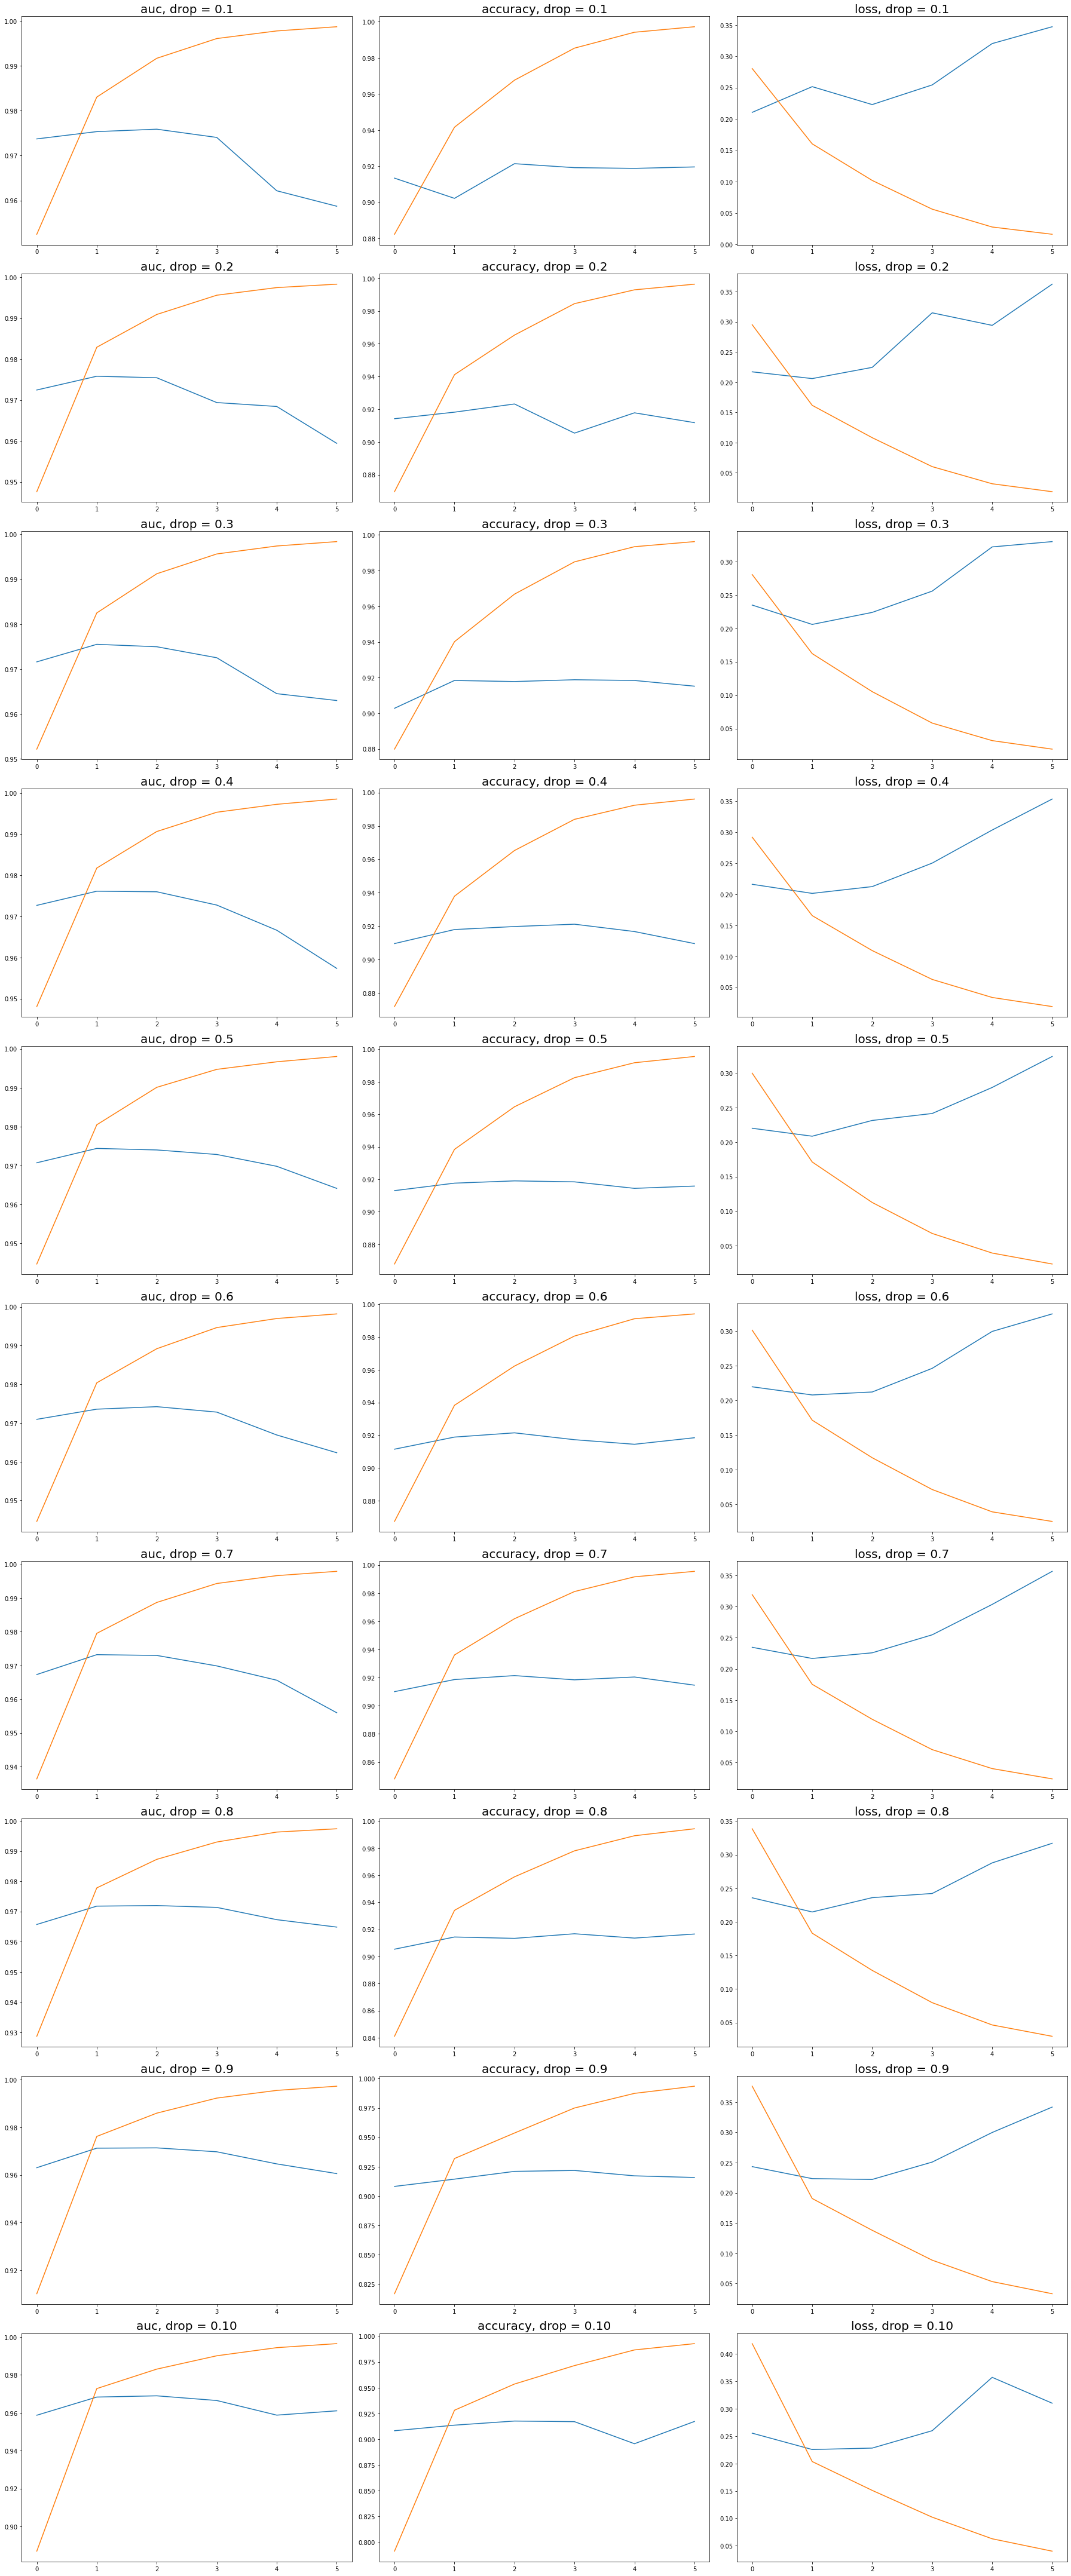

In [14]:
for i in ["0","1","2","3","4","5","6","7","8","9"]:
    with open('../input/bert-final-data/histories/trainHistoryDict_0.'+ i, 'rb') as f:
        globals()["history"+i] = pickle.load(f)
        f.close()
        
print("history_0['roc'] = ",max(history0['val_auc']),"\n", "history_1['roc'] = ",max(history1['val_auc']),"\n","history_2['roc'] = ",max(history2['val_auc']),"\n","history_3['roc'] = ",max(history3['val_auc']),"\n",
     "history_4['roc'] = ",max(history4['val_auc']),"\n","history_5['roc'] = ",max(history5['val_auc']),"\n","history_6['roc'] = ",max(history6['val_auc']),"\n","history_7['roc'] = ",max(history7['val_auc']),"\n",
     "history_8['roc'] = ",max(history8['val_auc']),"\n","history_9['roc'] = ",max(history9['val_auc']),"\n")


print("history_0['val_accuracy'] = ",max(history0['val_accuracy']),"\n", "history_1['val_accuracy'] = ",max(history1['val_accuracy']),"\n","history_2['val_accuracy'] = ",max(history2['val_accuracy']),"\n","history_3['val_accuracy'] = ",max(history3['val_accuracy']),"\n",
     "history_4['val_accuracy'] = ",max(history4['val_accuracy']),"\n","history_5['val_accuracy'] = ",max(history5['val_accuracy']),"\n","history_6['val_accuracy'] = ",max(history6['val_accuracy']),"\n","history_7['val_accuracy'] = ",max(history7['val_accuracy']),"\n",
     "history_8['val_accuracy'] = ",max(history8['val_accuracy']),"\n","history_9['val_accuracy'] = ",max(history9['val_accuracy']),"\n")

figure(figsize=(25, 60))
i = 0
drop = 0
epoch = list(range(6))
for history in (history0,history1,history2,history3,history4,history5,history6,history7,history8,history9):
    drop = drop + 1
    for _ in ["auc","accuracy","loss"]:
        i = i+1
        plt.subplot(10, 3, i)
        val = history["val_"+ _]
        train = history[_]
        plt.title(_ + ", drop = 0." + str(drop),fontsize=20)
        plt.plot(epoch,val,train)
        
plt.tight_layout()

## Appendix C: Learning curve scikit's style (but with no CV)

In this appendix, we study the learning curve emulating what scikit's [`learning_curve`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) does, even though with no cross-validation. 

```python
def bert():
    Bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)
    max_seq_length = 512
    METRICS = [ 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.AUC(name='auc'),
    ]

    input_word_ids = tf.keras.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

    _ , sequence_output = Bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :] # opzione 1
    mean = tf.reduce_mean(sequence_output, 1) # opzione 2
    out = Dense(512, activation='relu')(clf_output)
    # note: here we could insert a dropout layer: we chose not to put it (so drop = 0) because drop exploration (see Appendix B) pointed no signicant performance oscillation when we vary the drop.
    final = Dense(1, activation='sigmoid')(out)
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=final)
    # compile and summary
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=METRICS)
    return model


# function to split the dataset in varying train_sizes.
def bsp(a):
    l = len(train_input[0])
    f_t,f_v = train_input[0][:m.floor((l/10.)*a)], train_input[0][m.ceil((l/10.)*a):]
    s_t,s_v = train_input[1][:m.floor((l/10.)*a)], train_input[1][m.ceil((l/10.)*a):]
    t_t,t_v = train_input[2][:m.floor((l/10.)*a)], train_input[2][m.ceil((l/10.)*a):]
    t_labels, v_labels = train_labels[:m.floor((l/10.)*a)], train_labels[m.ceil((l/10.)*a):]
    return ([f_t,s_t,t_t],t_labels,[f_v,s_v,t_v],v_labels)

tv_list = [bsp(1), bsp(2),bsp(3),bsp(4),bsp(5),bsp(6),bsp(7),bsp(8),bsp(9)] 

histories = []
scores = []
i = 0
for train, train_labels, val, val_labels in tv_list:
    model = bert()
    histories.append(model.fit(train, train_labels, epochs = 1, batch_size = 12, verbose = 10, validation_data =(val, val_labels)))
    scores.append(model.evaluate(test_input, test_labels, batch_size=12))
    
with open("../working/histories","wb") as f:
    pickle.dump(histories, f)
    f.close()
    
with open("../working/scores.txt","wb") as f:
    pickle.dump(scores,f)
    f.close()
    
    
train_sizes = [2500, 5000, 7500, 10000, 12500, 15000,17500, 20000,22500]
# Value registrered from multiple external runs. They indicatively come from the scores array.
val_loss = [0.3274896603425344,0.26186237920895217,0.23470225021753993,0.22762819954156877,
           0.216497525832057,0.2152899844624102,0.20779933777451515,0.21191885358542203,
           0.20974656864404678]
val_acc = [0.8679111,0.89575,0.90445715,0.90966666,0.91568,0.9156,0.91746664,0.9148,0.9168]
val_auc = [0.94070125,0.96067715,0.96674746,0.9698138,0.97157085,0.9726143,0.97413814,0.9736698,
          0.97376865]
test_loss =[0.3185957675123215,0.25469263674438,0.22447200367122888,0.21847399472922086,
            0.20618302688077092,0.20828087054461242,0.1975343844014406,0.195971505715549,
           0.19205443421170115] 
test_acc = [0.87296,0.8956,0.9102, 0.91256,0.91952,0.91804,0.92284,0.9228,0.92576]
test_auc = [ 0.9453321,0.9641768,0.9700355,0.97299325,0.97432345,0.9750733,0.97692096, 0.97718656,
           0.9778782]
plt.figure(figsize=(25,6.5))
plt.subplot(1, 3, 1)

plt.title("loss" ,fontsize=20)
plt.xlabel("train_size")
plt.ylabel("loss")

plt.plot(train_sizes,val_loss, "o-", label = "val_loss")
plt.plot(train_sizes,test_loss, "o-", label = "test_loss")
plt.legend()

plt.subplot(1, 3, 2)

plt.title("accuracy" ,fontsize=20)
plt.xlabel("train_size")
plt.ylabel("accuracy")

plt.plot(train_sizes,val_acc, "o-", label = "val_acc")
plt.plot(train_sizes,test_acc, "o-", label = "test_acc")
plt.legend()

plt.subplot(1, 3, 3)

plt.title("roc_auc" ,fontsize=20)
plt.xlabel("train_size")
plt.ylabel("roc_auc")

plt.plot(train_sizes,val_auc, "o-", label = "val_auc")
plt.plot(train_sizes,test_auc, "o-", label = "test_auc")
plt.legend()
plt.savefig(r"../working/LAR1.png")

plt.tight_layout()
```

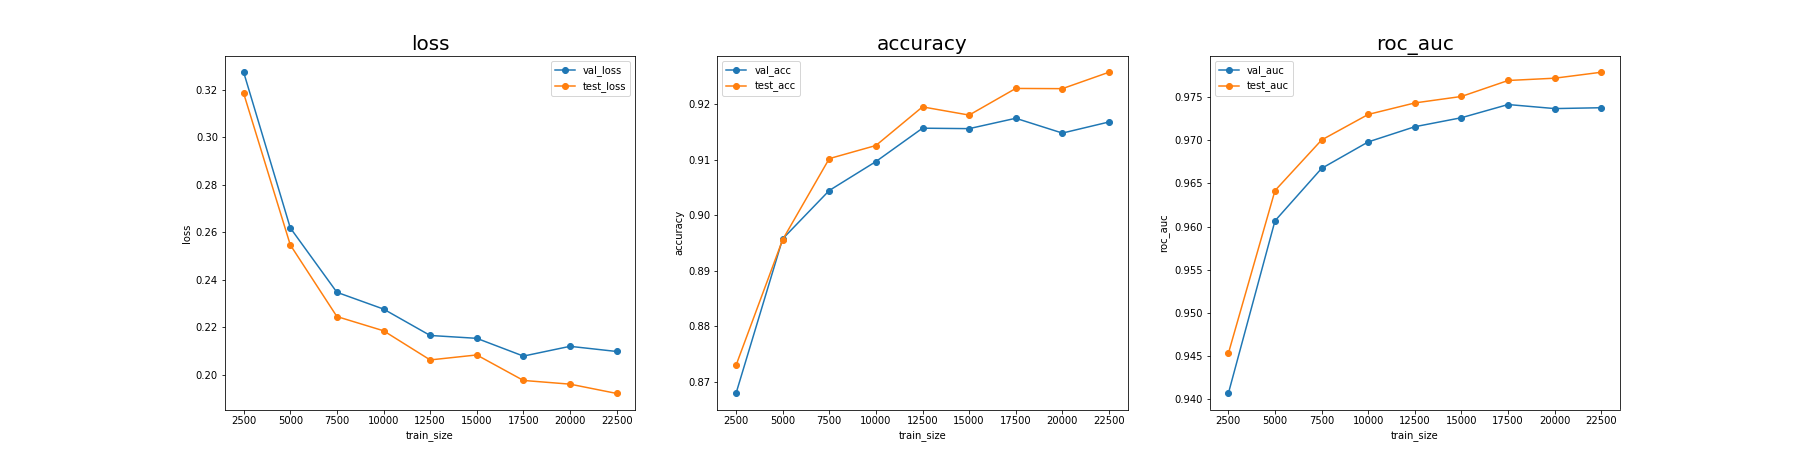

In [15]:
Image(width= "100%",filename= r'../input/bert-final-data/LAR2.png')